# **Twitter Sentiment Analysis**

### **Import**

In [0]:
import io
import codecs
import json

import keras
import nltk

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from tqdm import tqdm

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer, TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer

from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Flatten, Input, concatenate
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, SpatialDropout1D 
from keras.layers import GRU, LSTM, Bidirectional

Using TensorFlow backend.


In [0]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [0]:
! nvidia-smi

Sun Mar 31 09:37:28 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Link drive data

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1RmOEI3BkcjtY5SODeJNyst-zzjWKV1F4'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('train.csv')

In [0]:
file_id = '1ZUVxQ_FXXB6sY_x47v6JWk0Xswyx11NB'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('wiki.vec')

## **Importation de données**

In [0]:
df_train = pd.read_csv('train.csv')

In [0]:
df_train.head()

,label,id,date,flag,user,text
0,4,1973775248,Sat May 30 11:48:37 PDT 2009,NO_QUERY,mjs4320,Home from work!
1,0,1974556938,Sat May 30 13:22:31 PDT 2009,NO_QUERY,dougc84,@maeband did you guy's show sell out? i can't...
2,0,2202399576,Tue Jun 16 21:43:52 PDT 2009,NO_QUERY,Rebekkahcolburn,Did my poetry reading at kevro's tonight even ...
3,4,1962899636,Fri May 29 11:53:23 PDT 2009,NO_QUERY,addyct_d,google wave sounds really amazing... new way o...
4,0,1469846621,Tue Apr 07 07:35:31 PDT 2009,NO_QUERY,dilharasays,@thegutterflower sigh. true that.


In [0]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440001 entries, 0 to 1440000
Data columns (total 6 columns):
label    1440001 non-null int64
id       1440001 non-null int64
date     1440001 non-null object
flag     1440001 non-null object
user     1440001 non-null object
text     1440001 non-null object
dtypes: int64(2), object(4)
memory usage: 65.9+ MB


In [0]:
df_train['label'] = df_train['label'].replace(4, 1)

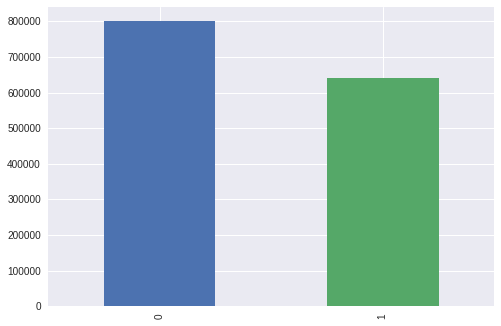

In [0]:
df_train['label'].value_counts().plot.bar();

### Load pre-processing

In [0]:
MAX_NB_WORDS = 100000

tweet_tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True)
regex_tokenizer = RegexpTokenizer(r'\w+')

lem = WordNetLemmatizer()

stop_words = set(stopwords.words('english'))

stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}', '<3'])

In [0]:
print(stop_words)

{'here', "aren't", 'not', '{', 'from', 'will', 'off', 'are', 'myself', 'should', 'wouldn', 'each', 'hadn', 'had', 'but', 'himself', "should've", 'your', 'most', 'on', 'now', 'over', 'hasn', 'i', 'itself', 't', "she's", 'nor', 'under', 'they', 'before', 'we', 'such', 'shouldn', 'ma', "hasn't", 'which', 'themselves', 'about', '<3', 'couldn', "haven't", "isn't", '.', 'again', 'ain', ':', 'further', 'been', 'he', 'out', 'haven', 'few', "wouldn't", 'when', '}', "didn't", "doesn't", 'those', 've', "it's", 'what', 'against', 'once', 'while', "mustn't", 'if', ']', 'was', 'both', "you've", 'them', 'down', 'no', 'll', 'so', 'herself', 'have', 'm', 'our', "you'll", '"', ',', 'any', 'in', 'needn', 'my', 'her', 'be', "won't", 'she', 'being', 'why', "shan't", 'don', 'him', 'to', 'did', 'his', 'up', 'does', 'yourself', 'who', 'an', 'the', 'or', 'of', "hadn't", 'you', 'through', 'because', 'as', 'some', 'during', 'how', 'o', 'isn', 'other', 'didn', 'mustn', ';', 'is', 'between', "'", 'at', 'only', "co

### Load Embeddings

In [0]:
embeddings_index = {}
f = codecs.open('wiki.vec', encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))

999995it [01:56, 8589.23it/s]

found 999995 word vectors


### Tweet length distribution

In [0]:
df_train['doc_len'] = df_train['text'].apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(df_train['doc_len'].mean() + df_train['doc_len'].std()).astype(int)

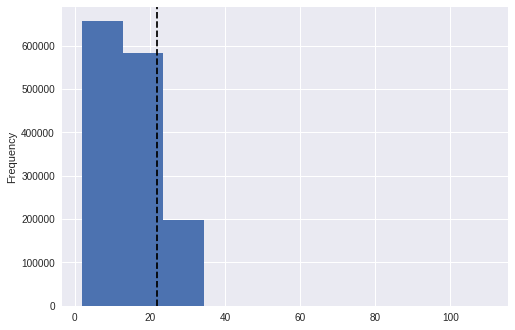

In [0]:
df_train['doc_len'].plot.hist()
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len');

## Pre-processing

In [0]:
raw_text = df_train['text'].tolist()

In [0]:
processed_text_bis = []
for tweet in tqdm(raw_text):
    tokens = tweet_tokenizer.tokenize(tweet)
#    filtered = [word for word in tokens if word not in stop_words]
#     filtered = [lem.lemmatize(word) for word in filtered]
#     filtered = [lem.lemmatize(word, "n") for word in filtered]
    filtered = [lem.lemmatize(word, "v") for word in tokens]
#     filtered = [lem.lemmatize(word, "a") for word in filtered]
#     filtered = [lem.lemmatize(word, "r") for word in filtered]
    processed_text_bis.append(" ".join(filtered))

100%|██████████| 1440001/1440001 [03:40<00:00, 6538.21it/s]


In [0]:
processed_text_bis[:20]

['Home from work !',
 "do you guy's show sell out ? i can't buy a ticket ... and i'm come from richmond ...",
 "Did my poetry read at kevro's tonight even though none of my friends be watch",
 'google wave sound really amaze ... new way of communicate on the internet',
 'sigh . true that .',
 'ahhh .. i dont have a blackberry .',
 'Very true ! nowt wrong with whingeing . No cottage over here',
 'Finally back bout to get ready for work ... and its official i hate HATE HATE bomb diver ouch !',
 "Now I don't dare to open the window anymore & the smell be kill me",
 'My brother kick me out of the only xbox compatable room',
 'sorry ! I prefer to tweet on my pc .. not my crummy palm centro plus lot go on in the " real worl " lol',
 'Good morning ^ ^ ... http://www.mtv.it/tv/programmi/trl/msn/index.asp VOTE ! ! ! for CB ! ! !',
 "I get a dodge intrepid 99 ' and thankxx I'm gladd yu approve",
 'H1N1 virus .. take care friends !',
 'anyone see the #beejive update ? I no see it',
 'sit at home 

In [0]:
processed_text = []
for tweet in tqdm(processed_text_bis):
    tokens = regex_tokenizer.tokenize(tweet)
    processed_text.append(" ".join(tokens))

100%|██████████| 1440001/1440001 [00:06<00:00, 206637.81it/s]


In [0]:
processed_text[:20]

['Home from work',
 'do you guy s show sell out i can t buy a ticket and i m come from richmond',
 'Did my poetry read at kevro s tonight even though none of my friends be watch',
 'google wave sound really amaze new way of communicate on the internet',
 'sigh true that',
 'ahhh i dont have a blackberry',
 'Very true nowt wrong with whingeing No cottage over here',
 'Finally back bout to get ready for work and its official i hate HATE HATE bomb diver ouch',
 'Now I don t dare to open the window anymore the smell be kill me',
 'My brother kick me out of the only xbox compatable room',
 'sorry I prefer to tweet on my pc not my crummy palm centro plus lot go on in the real worl lol',
 'Good morning http www mtv it tv programmi trl msn index asp VOTE for CB',
 'I get a dodge intrepid 99 and thankxx I m gladd yu approve',
 'H1N1 virus take care friends',
 'anyone see the beejive update I no see it',
 'sit at home very bore x',
 'Ooooh Its an amaze morning im up early And i hear Waking Up In

### Tokenize

In [0]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
tokenizer.fit_on_texts(processed_text)
word_seq = tokenizer.texts_to_sequences(processed_text)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

dictionary size:  303100


In [0]:
word_seq = sequence.pad_sequences(word_seq, maxlen=max_seq_len)

In [0]:
word_seq.shape

(1440001, 22)

In [0]:
y_true = df_train['label'].values

In [0]:
y_true.shape

(1440001,)

### Embeddings

In [0]:
embed_dim = 300

In [0]:
words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) == 300:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

number of null word embeddings: 44309


In [0]:
print("sample words not found: ", np.random.choice(words_not_found, 10))

sample words not found:  ['unfourtunately' 'australie' 'berrie' '3pf7v' 'ringin' 'vä' 'yihee'
 'examn' 'theemm' 'aswelll']


## Model

In [0]:
def create_model():
  
  inp = Input(shape=(max_seq_len,))
  x = Embedding(nb_words, embed_dim,
                weights=[embedding_matrix],
                input_length=max_seq_len, trainable=False)(inp)
  x1 = Conv1D(200, 3, activation='relu', padding='same')(x)
  #x1 = SpatialDropout1D(0.2)(x1)
  x1 = GlobalMaxPooling1D()(x1)
  
  x2 = Conv1D(200, 4, activation='relu', padding='same')(x)
  #x2 = SpatialDropout1D(0.2)(x2)
  x2 = GlobalMaxPooling1D()(x2)
  
  x3 = Conv1D(200, 5, activation='relu', padding='same')(x)
  #x3 = SpatialDropout1D(0.2)(x3)
  x3 = GlobalMaxPooling1D()(x3)
  
  x = concatenate([x1, x2, x3])
  x = Dropout(0.5)(x)
  x = Dense(30, activation='relu')(x)
  x = Dropout(0.5)(x)
  x = Dense(1, activation='sigmoid')(x)
  
  model = Model(inputs=inp, outputs=x)
  
  opt = optimizers.Adam(lr=0.001)
  
  model.compile(loss='binary_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])
  
  return model

In [0]:
model = create_model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 22)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 22, 300)      30000000    input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 22, 200)      180200      embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)    

In [0]:
history = model.fit(word_seq, y_true, batch_size=256, epochs=5,
                    validation_split=0.2)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 1152000 samples, validate on 288001 samples
Epoch 1/5
1152000/1152000 [==============================] - 122s 106us/step - loss: 0.4532 - acc: 0.7916 - val_loss: 0.4056 - val_acc: 0.8163
Epoch 2/5
1152000/1152000 [==============================] - 119s 103us/step - loss: 0.4198 - acc: 0.8119 - val_loss: 0.3943 - val_acc: 0.8218
Epoch 3/5
1152000/1152000 [==============================] - 119s 103us/step - loss: 0.4069 - acc: 0.8184 - val_loss: 0.3875 - val_acc: 0.8250
Epoch 4/5
1152000/1152000 [==============================] - 119s 103us/step - loss: 0.3978 - acc: 0.8239 - val_loss: 0.3837 - val_acc: 0.8270
Epoch 5/5
1152000/1152000 [==============================] - 119s 103us/step - loss: 0.3903 - acc: 0.8275 - val_loss: 0.3830 - val_acc: 0.8278


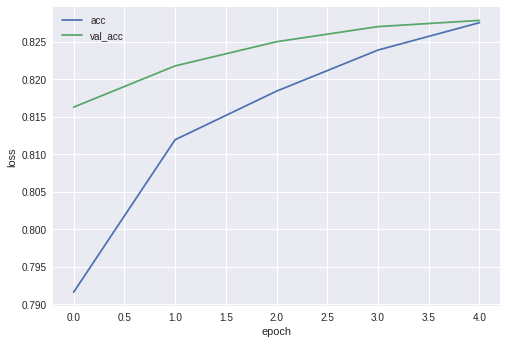

In [0]:
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend();

## Save model

In [0]:
model.save('my_model.h5')

In [0]:
tokenizer_json = tokenizer.to_json()
with io.open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

## Test on new sentence

In [0]:
def predict(text):
  # pre-process text
    tokens = tweet_tokenizer.tokenize(text)
    processed_text = " ".join(tokens)
    
    tokens = regex_tokenizer.tokenize(processed_text)
    processed_text = [" ".join(tokens)]
    
    word_seq = tokenizer.texts_to_sequences(processed_text)
    word_seq = sequence.pad_sequences(word_seq, maxlen=max_seq_len)
    
    pred = model.predict(word_seq)
    
    print(pred)

In [0]:
text = "Python is very good !"

In [0]:
predict(text)

[[0.9870812]]


# End